# Sentiment Expert Training (MULTI-SYMBOL) (DVC + MLflow)

This notebook trains a **sentiment-only** baseline expert using the **daily aggregated FinBERT features** produced by the news feature-build pipeline, and joins them with the OHLCV-derived label (`y_up_*d`).

Flow:
- Clone repo + `dvc pull` (reproducible dataset version)
- Load `news_sentiment_features.parquet` + OHLCV labels
- Apply the same metadata-driven date splits (from OHLCV metadata)
- TrainCV (TimeSeriesSplit) on TRAIN only, select via VAL, refit on TRAIN+VAL
- Log to MLflow + register model


In [1]:
# Install deps (Colab)
!pip -q install feast==0.58.0 s3fs boto3 pyarrow pandas scikit-learn "mlflow>=2.12,<3" "dagshub==0.6.4" "dvc[s3]" transformers torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.8/201.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.3/113.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

## 1) Credentials / Environment
Set these using Colab `userdata` (or replace with your own method).

In [2]:
import os
from google.colab import userdata

# AWS
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_DEFAULT_REGION'] = userdata.get('AWS_DEFAULT_REGION') or 'us-east-1'

# MLflow (DAGsHub)
os.environ["DAGSHUB_USER_TOKEN"] = userdata.get('DAGSHUB_TOKEN')

missing = [k for k in ['AWS_ACCESS_KEY_ID','AWS_SECRET_ACCESS_KEY','DAGSHUB_USER_TOKEN'] if not os.environ.get(k)]
if missing:
    raise ValueError(f"Missing secrets in Colab userdata: {missing}")
print('Secrets loaded:', ', '.join(['AWS_ACCESS_KEY_ID','AWS_SECRET_ACCESS_KEY','AWS_DEFAULT_REGION','DAGSHUB_USER_TOKEN']))

Secrets loaded: AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_DEFAULT_REGION, DAGSHUB_USER_TOKEN


## 2) Clone repo + pull DVC dataset
This ensures `git_sha` and `.dvc` pointers exist locally, and that the dataset version is reproducible.

In [3]:
from pathlib import Path

REPO_NAME = "dissertation"  # change if needed
REPO_URL = f"https://github.com/Roncool13/{REPO_NAME}.git"
BRANCH_OR_COMMIT = "main"  # or a specific commit hash for perfect reproducibility

if not Path(REPO_NAME).exists():
    !git clone {REPO_URL}
%cd {REPO_NAME}
!git checkout {BRANCH_OR_COMMIT}

# Pull DVC-versioned dataset artifacts
!dvc pull data/features/ohlcv_features.parquet
!dvc pull data/features/ohlcv_feature_metadata.json
!dvc pull data/features/news_sentiment_features.parquet
!dvc pull data/features/news_sentiment_feature_metadata.json

%cd ..

Cloning into 'dissertation'...
remote: Enumerating objects: 815, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 815 (delta 196), reused 262 (delta 118), pack-reused 470 (from 1)
Receiving objects: 100% (815/815), 275.04 KiB | 1.96 MiB/s, done.
Resolving deltas: 100% (493/493), done.
/content/dissertation
Already on 'main'
Your branch is up to date with 'origin/main'.
Fetching
!
  0% |          |0/? [00:00<?,    ?files/s]
                                           
!
  0% |          |0/? [00:00<?,    ?files/s]
                                           
Fetching from s3:   0% 0/1 [00:00<?, ?file/s]
Fetching from s3:   0% 0/1 [00:00<?, ?file/s{'info': ''}]

  0% 0.00/550k [00:00<?, ?B/s]

  0% 0.00/550k [00:00<?, ?B/s{'info': ''}]

 12% 67.5k/550k [00:00<00:00, 618kB/s{'info': ''}]

 53% 289k/550k [00:00<00:00, 1.41MB/s{'info': ''}]

                                                  
Fetching from s3: 100% 1/1 [00:00

## 3) MLflow setup

In [4]:
import mlflow
import dagshub

dagshub.init(repo_owner='Roncool13', repo_name='dissertation-mlflow', mlflow=True)
mlflow.set_experiment("dissertation-sentiment-prediction")
mlflow.sklearn.autolog(disable=True)

print('MLflow tracking URI:', mlflow.get_tracking_uri())

Accessing as Roncool13

Initialized MLflow to track repo "Roncool13/dissertation-mlflow"

Repository Roncool13/dissertation-mlflow initialized!

MLflow tracking URI: https://dagshub.com/Roncool13/dissertation-mlflow.mlflow


## 4) Reproducibility + dataset lineage logging (Git + DVC)

In [5]:
import subprocess
import hashlib
import json
import numpy as np
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

def _run(cmd):
    return subprocess.check_output(cmd, text=True).strip()

def _sha256_file(path):
    h = hashlib.sha256()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(1024*1024), b''):
            h.update(chunk)
    return h.hexdigest()

def log_code_and_data_version():
    # Git commit
    try:
        mlflow.set_tag('git_sha', _run(['git','rev-parse','HEAD']))
    except Exception:
        mlflow.set_tag('git_sha', 'unavailable')

    # DVC pointer hashes (these change when the dataset changes)
    for tag, p in [
        ('dvc_ptr_features_sha256', f'{REPO_NAME}/data/features/ohlcv_features.parquet.dvc'),
        ('dvc_ptr_metadata_sha256', f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json.dvc'),
    ]:
        try:
            mlflow.set_tag(tag, _sha256_file(p))
        except Exception:
            mlflow.set_tag(tag, 'unavailable')

    # Log pointer files + metadata as artifacts (small, very useful)
    for p, ap in [
        (f'{REPO_NAME}/data/features/ohlcv_features.parquet.dvc', 'dataset_pointers'),
        (f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json.dvc', 'dataset_pointers'),
        (f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json', 'dataset_metadata'),
    ]:
        try:
            mlflow.log_artifact(p, artifact_path=ap)
        except Exception:
            pass

    # Log key metadata as params/tags
    meta = json.loads(Path(f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json').read_text())
    splits = meta.get('splits', {})

    mlflow.log_params({
        'dataset_name': 'ohlcv_features',
        'symbols_count': meta.get('symbols_count', len(meta.get('symbols', []))),
        'start_year': meta.get('start_year'),
        'end_year': meta.get('end_year'),
        'horizon_days': meta.get('horizon_days'),
        'lags': ','.join(map(str, meta.get('lags', []))),
        'split_scheme': splits.get('scheme'),
        'seed': SEED,
    })

    if 'train' in splits and 'val' in splits and 'test' in splits:
        mlflow.set_tags({
            'train_period': f"{splits['train']['start']}:{splits['train']['end']}",
            'val_period': f"{splits['val']['start']}:{splits['val']['end']}",
            'test_period': f"{splits['test']['start']}:{splits['test']['end']}",
        })

print('Seed set to', SEED)

Seed set to 42


## 5) Load dataset + apply metadata-driven splits
We use OHLCV metadata splits (train/val/test date ranges) so that expert models are comparable on the same time windows.

In [25]:
import re
import pandas as pd
import numpy as np
import json
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# --- Load sentiment features ---
sent = pd.read_parquet(f'{REPO_NAME}/data/features/news_sentiment_features.parquet')
news_meta = json.loads(Path(f'{REPO_NAME}/data/features/news_sentiment_feature_metadata.json').read_text())

print(f"Sentiment features columns: {len(sent.columns)}")
print("Sentiment head:\n", sent.head(2))

# --- Load OHLCV for splits (and labels only if needed) ---
ohlcv = pd.read_parquet(f'{REPO_NAME}/data/features/ohlcv_features.parquet')
ohlcv_meta = json.loads(Path(f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json').read_text())

# Ensure datetime
for _df in (sent, ohlcv):
    _df["date"] = pd.to_datetime(_df["date"])

# Optional: single symbol baseline
SYMBOL = None  # set to "TCS" for debugging, else None for multisymbol
if SYMBOL:
    sent = sent[sent["symbol"] == SYMBOL].copy()
    ohlcv = ohlcv[ohlcv["symbol"] == SYMBOL].copy()

# Label column name (from sentiment metadata supervision)
label_col = news_meta["supervision"]["label_col_name"]
print("Label col:", label_col)

key_cols = ["symbol", "date"]

# ---------- (1) leakage-safe shift ----------
sent = sent.sort_values(key_cols).reset_index(drop=True)

sent_feature_cols = [c for c in sent.columns if c not in key_cols and c != label_col]

# Detect if pipeline already produced lag/roll features (so shifting again would double-shift)
already_lagged = any(("_lag_" in c) or ("_roll_" in c) for c in sent_feature_cols)

# Optional: metadata-driven flag (use if you store it in news_meta)
meta_shift = None
try:
    meta_shift = news_meta.get("supervision", {}).get("feature_shift_days", None)
except Exception:
    meta_shift = None

if (meta_shift == 1) or already_lagged:
    print("Skipping notebook shift: sentiment features already leakage-safe (lags/rolls present or metadata says shifted).")
else:
    print("WARNING: No lag/roll features detected and metadata does not indicate pre-shifting.\n"
          "In multi-symbol training, we *do not* apply notebook shifting by default to avoid mismatching the feature-build logic.\n"
          "If you are sure your features are same-day (leaky), set meta_shift=0 and enable shifting explicitly.")

# ---------- (2) Build df with a SINGLE label source (avoid _x/_y collisions) ----------
if label_col in sent.columns:
    # Use label already present in sentiment parquet
    df = sent.copy()
    # Ensure label not NaN
    df = df.dropna(subset=[label_col]).reset_index(drop=True)
    print(f"Using label from sentiment features parquet: {label_col}")
else:
    # Merge label from OHLCV only if sentiment parquet doesn't have it
    labels = ohlcv[["symbol", "date", label_col]].dropna(subset=[label_col]).copy()
    df = sent.merge(labels, on=key_cols, how="inner").reset_index(drop=True)
    print(f"Using label from OHLCV merge: {label_col}")

df = df.sort_values(key_cols).reset_index(drop=True)

# ---------- (3) sanity checks: alignment + duplicates ----------
# No duplicate (symbol,date)
dup_cnt = int(df.duplicated(subset=key_cols).sum())
print("Duplicate (symbol,date) rows:", dup_cnt)
if dup_cnt > 0:
    # Keep the first occurrence deterministically
    df = df.drop_duplicates(subset=key_cols, keep="first").reset_index(drop=True)
    print("Dropped duplicates. New rows:", len(df))

# Confirm label column exists exactly
assert label_col in df.columns, f"Label column {label_col} missing. Columns contain: {[c for c in df.columns if 'y_' in c][:20]}"

# Confirm no leftover suffix label columns
suffix_cols = [c for c in df.columns if c in [f"{label_col}_x", f"{label_col}_y"]]
if suffix_cols:
    raise RuntimeError(f"Found suffix label columns {suffix_cols}. This should not happen with single-source label logic.")

# ---------- (4) Apply OHLCV metadata-driven splits ----------
splits = None
# Prefer NEWS metadata supervision splits (comes from OHLCV metadata inside feature build)
try:
    if news_meta.get("supervision", {}).get("enabled") and news_meta.get("supervision", {}).get("splits"):
        splits = news_meta["supervision"]["splits"]
except Exception:
    splits = None
# Fallback to OHLCV metadata
if not splits:
    splits = ohlcv_meta["splits"]


def split_by_date(frame, split):
    start = pd.to_datetime(split["start"])
    end = pd.to_datetime(split["end"])
    return frame[(frame["date"] >= start) & (frame["date"] <= end)].copy()

train_df = split_by_date(df, splits["train"])
val_df   = split_by_date(df, splits["val"])
test_df  = split_by_date(df, splits["test"])

print("Merged df rows:", len(df))
print("Date min/max:", df["date"].min(), df["date"].max())
print("Shapes -> train/val/test:", train_df.shape, val_df.shape, test_df.shape)

for name, part in [("train", train_df), ("val", val_df), ("test", test_df)]:
    if len(part) == 0:
        print(name, "EMPTY")
        continue
    print(name, "class balance:", part[label_col].value_counts(normalize=True).to_dict())
    # quick signal check: do we have variance in features?
    print(name, "feature variance sanity (std of 3 cols):",
          {c: float(part[c].std()) for c in sent_feature_cols[:3]})

Sentiment features columns: 130
Sentiment head:
   symbol       date  article_count  pos_count  neg_count  neu_count  \
0    TCS 2021-01-01           10.0          6          0          4   
1    TCS 2021-01-04           19.0         17          0          2   

   highrel_count  rel_score_mean  sent_conf_mean  polarity_mean  polarity_std  \
0              0        0.016140        0.862809       0.600000      0.516398   
1              0        0.009732        0.858335       0.894737      0.315302   

   polarity_wmean  highrel_polarity_mean  highrel_polarity_wmean  pos_ratio  \
0        0.736733                    0.0                     0.0   0.600000   
1        0.935498                    0.0                     0.0   0.894737   

   neg_ratio  neu_ratio  highrel_ratio  sent_cov  sent_abs  imbalance  \
0        0.0   0.400000            0.0  1.766608  0.736733   0.600000   
1        0.0   0.105263            0.0  2.802500  0.935498   0.894737   

   highrel_impact  news_present  ar

In [26]:
import pandas as pd
import numpy as np

# Create a sample DataFrame with many columns and rows
data = np.random.rand(50, 20)
columns = [f'col_{i}' for i in range(20)]
df_example = pd.DataFrame(data, columns=columns)

# Display the DataFrame with default options (likely truncated)
print("Default display (might be truncated):")
display(df_example.head())

# Set options to display all columns and up to 100 rows
pd.set_option('display.max_columns', None) # Display all columns
pd.set_option('display.max_rows', 100)    # Display up to 100 rows

print("\nDisplay with increased limits (all columns, more rows):")
display(df_example)

# To reset to default display options:
# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_rows')

print("\nDisplaying first 10 rows to illustrate row handling (if max_rows < actual rows):")
display(df_example.head(10))

Default display (might be truncated):


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
0,0.261706,0.246979,0.906255,0.249546,0.271950,0.759398,0.449740,0.776711,0.065366,0.487571,0.033614,0.062653,0.906437,0.139245,0.532421,0.411096,0.347343,0.899833,0.021823,0.663790
1,0.963394,0.560168,0.936822,0.052258,0.418793,0.260158,0.730821,0.981297,0.256530,0.654175,0.198098,0.565330,0.463932,0.972005,0.608527,0.349506,0.114096,0.151247,0.225317,0.250967
2,0.850616,0.561223,0.523391,0.114769,0.860140,0.722814,0.067668,0.707835,0.543538,0.081725,0.458301,0.484696,0.165775,0.945698,0.849975,0.669022,0.462296,0.411766,0.650973,0.545432
3,0.062273,0.512503,0.806404,0.459240,0.051957,0.786278,0.201364,0.258621,0.164706,0.330215,0.756752,0.519386,0.204881,0.877830,0.879582,0.870578,0.238796,0.451239,0.984990,0.772012
4,0.027167,0.065205,0.463931,0.909220,0.538702,0.497813,0.105474,0.656780,0.822103,0.380420,0.775612,0.964477,0.203766,0.523330,0.287138,0.792854,0.577593,0.634582,0.797914,0.395970



Display with increased limits (all columns, more rows):


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
0,0.261706,0.246979,0.906255,0.249546,0.271950,0.759398,0.449740,0.776711,0.065366,0.487571,0.033614,0.062653,0.906437,0.139245,0.532421,0.411096,0.347343,0.899833,0.021823,0.663790
1,0.963394,0.560168,0.936822,0.052258,0.418793,0.260158,0.730821,0.981297,0.256530,0.654175,0.198098,0.565330,0.463932,0.972005,0.608527,0.349506,0.114096,0.151247,0.225317,0.250967
2,0.850616,0.561223,0.523391,0.114769,0.860140,0.722814,0.067668,0.707835,0.543538,0.081725,0.458301,0.484696,0.165775,0.945698,0.849975,0.669022,0.462296,0.411766,0.650973,0.545432
3,0.062273,0.512503,0.806404,0.459240,0.051957,0.786278,0.201364,0.258621,0.164706,0.330215,0.756752,0.519386,0.204881,0.877830,0.879582,0.870578,0.238796,0.451239,0.984990,0.772012
4,0.027167,0.065205,0.463931,0.909220,0.538702,0.497813,0.105474,0.656780,0.822103,0.380420,0.775612,0.964477,0.203766,0.523330,0.287138,0.792854,0.577593,0.634582,0.797914,0.395970
5,0.915090,0.533029,0.157955,0.695899,0.793261,0.316762,0.857179,0.906143,0.276904,0.983521,0.140712,0.202016,0.184225,0.893990,0.654293,0.152104,0.440323,0.615298,0.083464,0.882416
6,0.803604,0.505207,0.967127,0.417761,0.984110,0.667920,0.634671,0.165955,0.881928,0.427490,0.162233,0.012608,0.559756,0.527400,0.719354,0.890258,0.079407,0.731496,0.187412,0.858177
7,0.819064,0.540794,0.710243,0.314350,0.471168,0.821637,0.459265,0.357798,0.494212,0.828249,0.335208,0.173762,0.712014,0.825978,0.100637,0.239874,0.141972,0.347941,0.450351,0.748826
8,0.651148,0.620929,0.352375,0.841448,0.471287,0.979105,0.634142,0.126265,0.676178,0.325104,0.686327,0.069641,0.174881,0.855737,0.227180,0.837041,0.279276,0.642882,0.694151,0.512655
9,0.305311,0.212644,0.033189,0.303946,0.653163,0.938305,0.871204,0.766065,0.788447,0.664985,0.260287,0.907195,0.670732,0.560441,0.110989,0.447056,0.460358,0.864564,0.546648,0.380401



Displaying first 10 rows to illustrate row handling (if max_rows < actual rows):


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
0,0.261706,0.246979,0.906255,0.249546,0.271950,0.759398,0.449740,0.776711,0.065366,0.487571,0.033614,0.062653,0.906437,0.139245,0.532421,0.411096,0.347343,0.899833,0.021823,0.663790
1,0.963394,0.560168,0.936822,0.052258,0.418793,0.260158,0.730821,0.981297,0.256530,0.654175,0.198098,0.565330,0.463932,0.972005,0.608527,0.349506,0.114096,0.151247,0.225317,0.250967
2,0.850616,0.561223,0.523391,0.114769,0.860140,0.722814,0.067668,0.707835,0.543538,0.081725,0.458301,0.484696,0.165775,0.945698,0.849975,0.669022,0.462296,0.411766,0.650973,0.545432
3,0.062273,0.512503,0.806404,0.459240,0.051957,0.786278,0.201364,0.258621,0.164706,0.330215,0.756752,0.519386,0.204881,0.877830,0.879582,0.870578,0.238796,0.451239,0.984990,0.772012
4,0.027167,0.065205,0.463931,0.909220,0.538702,0.497813,0.105474,0.656780,0.822103,0.380420,0.775612,0.964477,0.203766,0.523330,0.287138,0.792854,0.577593,0.634582,0.797914,0.395970
5,0.915090,0.533029,0.157955,0.695899,0.793261,0.316762,0.857179,0.906143,0.276904,0.983521,0.140712,0.202016,0.184225,0.893990,0.654293,0.152104,0.440323,0.615298,0.083464,0.882416
6,0.803604,0.505207,0.967127,0.417761,0.984110,0.667920,0.634671,0.165955,0.881928,0.427490,0.162233,0.012608,0.559756,0.527400,0.719354,0.890258,0.079407,0.731496,0.187412,0.858177
7,0.819064,0.540794,0.710243,0.314350,0.471168,0.821637,0.459265,0.357798,0.494212,0.828249,0.335208,0.173762,0.712014,0.825978,0.100637,0.239874,0.141972,0.347941,0.450351,0.748826
8,0.651148,0.620929,0.352375,0.841448,0.471287,0.979105,0.634142,0.126265,0.676178,0.325104,0.686327,0.069641,0.174881,0.855737,0.227180,0.837041,0.279276,0.642882,0.694151,0.512655
9,0.305311,0.212644,0.033189,0.303946,0.653163,0.938305,0.871204,0.766065,0.788447,0.664985,0.260287,0.907195,0.670732,0.560441,0.110989,0.447056,0.460358,0.864564,0.546648,0.380401


### Explanation:

*   `pd.set_option('display.max_columns', None)`: This tells pandas to display all columns, regardless of how many there are. If you want to limit it to a specific number, replace `None` with an integer (e.g., `50`).
*   `pd.set_option('display.max_rows', 100)`: This sets the maximum number of rows to display to 100. If your DataFrame has more than 100 rows, it will still truncate, but if it has fewer, all rows will be shown. You can set this to `None` to display all rows without truncation, but be cautious with very large DataFrames as this can make your notebook very long.

To revert to pandas' default display settings, you can use `pd.reset_option('display.max_columns')` and `pd.reset_option('display.max_rows')`.

In [27]:
df[sent_feature_cols].describe().T[['mean','std','min','max']]

,mean,std,min,max
article_count,7.424528,9.202480,1.00000,67.000000
pos_count,3.265723,4.728885,0.00000,37.000000
neg_count,1.602201,2.811214,0.00000,23.000000
neu_count,2.556604,3.603359,0.00000,44.000000
highrel_count,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...
sent_cov_pos_shock,0.062893,0.242962,0.00000,1.000000
sent_cov_neg_shock,0.077044,0.266871,0.00000,1.000000
article_count_z20,0.095133,1.015275,-1.36334,4.138936
article_count_pos_shock,0.103774,0.305207,0.00000,1.000000


In [28]:
print("Merged rows:", len(df))
print("Date min/max:", df["date"].min(), df["date"].max())
print("Rows per year:", df["date"].dt.year.value_counts().sort_index().to_dict())

# After masks are built:
for name, mask in [("train", train_df), ("val", val_df), ("test", test_df)]:
    # part = df.loc[mask]
    print(name, "rows", len(part),
          "date_min", mask["date"].min(),
          "date_max", mask["date"].max(),
          "pos_rate", float(mask[label_col].mean()))

Merged rows: 636
Date min/max: 2021-01-01 00:00:00 2023-09-07 00:00:00
Rows per year: {2021: 243, 2022: 231, 2023: 162}
train rows 162 date_min 2021-01-01 00:00:00 date_max 2021-12-31 00:00:00 pos_rate 0.5925925925925926
val rows 162 date_min 2022-01-03 00:00:00 date_max 2022-12-30 00:00:00 pos_rate 0.49783549783549785
test rows 162 date_min 2023-01-02 00:00:00 date_max 2023-09-07 00:00:00 pos_rate 0.5493827160493827


## 6) Build feature matrix
We use only sentiment-derived features (daily aggregates + lags) keyed by (`symbol`, `date`).
We exclude:
- keys: `symbol`, `date`
- label column: `y_up_*d`


In [42]:
exclude_cols = {'symbol','date', label_col}

# If True, keep only features that are strictly "past-only" by construction
# (lags/rolling/z/shock features computed from prior days). This avoids any same-day leakage.
USE_CAUSAL_ONLY = False

if USE_CAUSAL_ONLY:
    X_cols = [
        c for c in df.columns
        if (c not in exclude_cols)
        and (
            ("_lag_" in c)
            or ("_roll_" in c)
            or (re.search(r"_z\d+$", c) is not None)
            or (c.endswith("_pos_shock") or c.endswith("_neg_shock"))
        )
    ]
else:
    X_cols = [c for c in df.columns if c not in exclude_cols]

MIN_SENT_FEATURES = [
    "polarity_wmean_lag_3",
    "sent_cov_lag_3",
    "imbalance_lag_3",
    "article_count_lag_3",
    "news_present_lag_3",
    "highrel_ratio_lag_3",   # optional but useful
]

X_cols = [c for c in X_cols if c in MIN_SENT_FEATURES]

# Drop any remaining NaNs
train_df = train_df.dropna(subset=X_cols + [label_col])
val_df   = val_df.dropna(subset=X_cols + [label_col])
test_df  = test_df.dropna(subset=X_cols + [label_col])

X_train, y_train = train_df[X_cols], train_df[label_col]
X_val, y_val     = val_df[X_cols], val_df[label_col]
X_test, y_test   = test_df[X_cols], test_df[label_col]

# float32 helps MLflow schema + memory
X_train = X_train.astype('float32')
X_val   = X_val.astype('float32')
X_test  = X_test.astype('float32')

print('Features:', len(X_cols), '| causal_only:', USE_CAUSAL_ONLY)
print('Train rows:', len(X_train), 'Val rows:', len(X_val), 'Test rows:', len(X_test))


Features: 6 | causal_only: False
Train rows: 243 Val rows: 231 Test rows: 162


In [43]:
X_cols

['article_count_lag_3',
 'highrel_ratio_lag_3',
 'polarity_wmean_lag_3',
 'sent_cov_lag_3',
 'imbalance_lag_3',
 'news_present_lag_3']

## 7) Train sentiment expert (TrainCV on TRAIN, select via VAL)

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef
import numpy as np
import pandas as pd
from mlflow.models.signature import infer_signature

# --- Multi-symbol CV: split by unique DATES (not by rows) ---
class DateGroupeddate-grouped split(BaseCrossValidator):
    def __init__(self, dates, n_splits=5):
        self.dates = pd.to_datetime(pd.Series(dates)).to_numpy()
        self.n_splits = n_splits

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        dates = self.dates
        uniq = np.unique(dates)
        uniq.sort()
        # Create expanding-window splits on date buckets
        edges = np.linspace(0, len(uniq), self.n_splits + 2, dtype=int)
        for i in range(self.n_splits):
            train_dates = uniq[:edges[i+1]]
            val_dates   = uniq[edges[i+1]:edges[i+2]]
            train_idx = np.where(np.isin(dates, train_dates))[0]
            val_idx   = np.where(np.isin(dates, val_dates))[0]
            yield train_idx, val_idx


# Ensure no nested/active MLflow run
if mlflow.active_run():
    mlflow.end_run()

# ---- Model + CV setup (CV only on TRAIN) ----
base_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1500, solver='liblinear', random_state=SEED, class_weight='balanced'))
])

param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'clf__penalty': ['l1', 'l2'],
    }

# date-grouped split expects TRAIN data already time-ordered (we ensured in earlier cells)
dates_train = train_df['date'].to_numpy()
cv = DateGroupeddate-grouped split(dates=dates_train, n_splits=5)

grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=False,  # IMPORTANT: we will pick using VAL, not CV refit
    return_train_score=False
)

with mlflow.start_run(run_name='sentiment_lr_multisym_min6_lag3') as run:
    run_id = run.info.run_id
    print('MLflow run:', run_id)
    log_code_and_data_version()

    # Multi-symbol diagnostics
    mlflow.log_metric('n_symbols_train', int(train_df['symbol'].nunique()))
    mlflow.log_metric('n_symbols_val', int(val_df['symbol'].nunique()))
    mlflow.log_metric('n_symbols_test', int(test_df['symbol'].nunique()))

    # ---- 1) GridSearch CV on TRAIN only ----
    grid.fit(X_train, y_train)

    # Log CV best (informational)
    best_cv_idx = int(np.argmax(grid.cv_results_['mean_test_score']))
    best_cv_params = grid.cv_results_['params'][best_cv_idx]
    best_cv_score = float(grid.cv_results_['mean_test_score'][best_cv_idx])

    mlflow.log_metric('traincv_best_mean_roc_auc', best_cv_score)
    mlflow.log_params({f'traincv_best_{k}': v for k, v in best_cv_params.items()})

    print('Best TRAIN-CV params:', best_cv_params)
    print('Best TRAIN-CV mean ROC-AUC:', best_cv_score)

    # ---- 2) Select final params using VAL ----
    # Evaluate each candidate on VAL by refitting on full TRAIN
    rows = []
    for params in grid.cv_results_['params']:
        m = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(
                max_iter=1500,
                solver='liblinear',
                random_state=SEED,
                C=params['clf__C'],
                penalty=params['clf__penalty'],
                class_weight='balanced',
            ))
        ])
        m.fit(X_train, y_train)
        val_proba = m.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, val_proba)
        rows.append({'val_roc_auc': float(val_auc), **params})

    val_rank = pd.DataFrame(rows).sort_values('val_roc_auc', ascending=False).reset_index(drop=True)
    best_val = val_rank.iloc[0].to_dict()

    best_val_params = {k: best_val[k] for k in param_grid.keys()}
    best_val_auc = float(best_val['val_roc_auc'])

    mlflow.log_metric('valselect_best_roc_auc', best_val_auc)
    mlflow.log_params({f'valselect_best_{k}': v for k, v in best_val_params.items()})

    print('\nBest VAL-selected params:', best_val_params)
    print('Best VAL ROC-AUC:', best_val_auc)

    # ---- 3) Refit final model on TRAIN+VAL with VAL-selected params ----
    X_trval = pd.concat([X_train, X_val], axis=0)
    y_trval = pd.concat([y_train, y_val], axis=0)

    final_model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            max_iter=1500,
            solver='liblinear',
            random_state=SEED,
            C=best_val_params['clf__C'],
            penalty=best_val_params['clf__penalty'],
            class_weight='balanced',
        ))
    ])

    final_model.fit(X_trval, y_trval)

    # ---- 4) Evaluate on VAL and TEST (VAL reported for completeness; selection already done) ----
    def eval_split(X, y, split_name):
        proba = final_model.predict_proba(X)[:, 1]
        pred = (proba >= 0.5).astype(int)
        metrics = {
            f'{split_name}_accuracy': accuracy_score(y, pred),
            f'{split_name}_roc_auc': roc_auc_score(y, proba),
            f'{split_name}_balanced_accuracy': balanced_accuracy_score(y, pred),
            f'{split_name}_mcc': matthews_corrcoef(y, pred),
        }
        mlflow.log_metrics(metrics)
        return metrics, proba

    # Evaluate using the final model
    val_metrics, val_proba = eval_split(X_val, y_val, 'val_final')
    test_metrics, test_proba = eval_split(X_test, y_test, 'test')

    print('\nVAL (final model):', val_metrics)
    print('TEST:', test_metrics)

    # ---- Optional: Log top-10 VAL candidates table as artifact ----
    topk = 10
    out_csv = 'val_candidate_ranking_top10.csv'
    val_rank.head(topk).to_csv(out_csv, index=False)
    mlflow.log_artifact(out_csv, artifact_path='model_selection')


    # ----- Log model with signature + input example -----
    input_example = X_train.head(5)
    proba_example = final_model.predict_proba(input_example)[:, 1]
    signature = infer_signature(input_example, proba_example)

    mlflow.sklearn.log_model(
        sk_model=final_model,
        artifact_path='model_final',
        input_example=input_example,
        signature=signature,
    )

    mlflow.set_tag('expert', 'sentiment')
    mlflow.set_tag('baseline_name', 'sentiment_lr_multisym')
    mlflow.set_tag('label_col', label_col)
    mlflow.set_tag('selection_protocol', 'train_timeseries_cv_val_select_refit_trainval')

# Register model
result = mlflow.register_model(
    model_uri=f"runs:/{run_id}/model_final",
    name='sentiment_lr_baseline_multisym'
)
print('Registered model version:', result.version)


MLflow run: 61728aedf98f4db4a0d5094e9ea53537
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best TRAIN-CV params: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1'}
Best TRAIN-CV mean ROC-AUC: 0.5248066748066748

Best VAL-selected params: {'clf__C': 0.001, 'clf__penalty': 'l2', 'clf__class_weight': 'balanced'}
Best VAL ROC-AUC: 0.5281109445277362

VAL (final model): {'val_final_accuracy': 0.5194805194805194, 'val_final_roc_auc': np.float64(0.5285607196401799), 'val_final_balanced_accuracy': np.float64(0.5197901049475262), 'val_final_mcc': np.float64(0.03999000374843818)}
TEST: {'test_accuracy': 0.4506172839506173, 'test_roc_auc': np.float64(0.41195936586116666), 'test_balanced_accuracy': np.float64(0.44828382330306293), 'test_mcc': np.float64(-0.10299731308114696)}
🏃 View run sentiment_lr_min6_lag3 at: https://dagshub.com/Roncool13/dissertation-mlflow.mlflow/#/experiments/1/runs/61728aedf98f4db4a0d5094e9ea53537
🧪 View experiment at: https://dagshub.co

Registered model 'sentiment_lr_baseline_tcs_2021_2023' already exists. Creating a new version of this model...
2026/01/26 11:26:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sentiment_lr_baseline_tcs_2021_2023, version 9


Registered model version: 9


Created version '9' of model 'sentiment_lr_baseline_tcs_2021_2023'.


In [45]:
import numpy as np
from sklearn.metrics import roc_auc_score

def auc_permutation_summary(y_true, scores, n_perm=5000, seed=42):
    rng = np.random.default_rng(seed)

    auc_obs = roc_auc_score(y_true, scores)

    perm_aucs = np.empty(n_perm)
    for i in range(n_perm):
        y_perm = rng.permutation(y_true)
        perm_aucs[i] = roc_auc_score(y_perm, scores)

    summary = {
        "auc_observed": auc_obs,
        "perm_auc_min": float(np.min(perm_aucs)),
        "perm_auc_max": float(np.max(perm_aucs)),
        "perm_auc_mean": float(np.mean(perm_aucs)),
        "perm_auc_std": float(np.std(perm_aucs, ddof=1)),
        "perm_auc_q025": float(np.quantile(perm_aucs, 0.025)),
        "perm_auc_q975": float(np.quantile(perm_aucs, 0.975)),
    }

    # p-values
    summary["p_two_sided"] = (
        np.sum(np.abs(perm_aucs - 0.5) >= abs(auc_obs - 0.5)) + 1
    ) / (n_perm + 1)

    summary["p_greater_0p5"] = (
        np.sum(perm_aucs >= auc_obs) + 1
    ) / (n_perm + 1)

    summary["p_less_0p5"] = (
        np.sum(perm_aucs <= auc_obs) + 1
    ) / (n_perm + 1)

    return summary, perm_aucs

In [46]:
summary_p, perm_p = auc_permutation_summary(
    y_test.to_numpy(), test_proba, n_perm=5000
)

summary_inv, perm_inv = auc_permutation_summary(
    y_test.to_numpy(), 1 - test_proba, n_perm=5000
)

print("=== Using p ===")
for k, v in summary_p.items():
    print(f"{k:20s}: {v}")

print("\n=== Using 1 - p ===")
for k, v in summary_inv.items():
    print(f"{k:20s}: {v}")

=== Using p ===
auc_observed        : 0.41195936586116666
perm_auc_min        : 0.36439895336309064
perm_auc_max        : 0.6556872402647376
perm_auc_mean       : 0.5020215176235185
perm_auc_std        : 0.045330573307720945
perm_auc_q025       : 0.4158784823764815
perm_auc_q975       : 0.5916653840233953
p_two_sided         : 0.05098980203959208
p_greater_0p5       : 0.979004199160168
p_less_0p5          : 0.021195760847830435

=== Using 1 - p ===
auc_observed        : 0.5880406341388335
perm_auc_min        : 0.34431275973526243
perm_auc_max        : 0.6356010466369095
perm_auc_mean       : 0.4979784823764814
perm_auc_std        : 0.04533057330772095
perm_auc_q025       : 0.4083346159766046
perm_auc_q975       : 0.5841215176235185
p_two_sided         : 0.05118976204759048
p_greater_0p5       : 0.021395720855828835
p_less_0p5          : 0.979004199160168


In [47]:
from sklearn.metrics import roc_auc_score

auc_p = roc_auc_score(y_test, test_proba)
auc_inv = roc_auc_score(y_test, 1 - test_proba)   # equals 1 - auc_p (up to float noise)

print("AUC(p):", auc_p)
print("AUC(1-p):", auc_inv)
print("AUC(p) + AUC(1-p):", auc_p + auc_inv)

AUC(p): 0.41195936586116666
AUC(1-p): 0.5880406341388335
AUC(p) + AUC(1-p): 1.0


## 8) Visualizations (ROC curves)

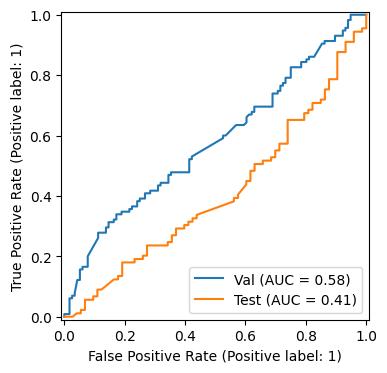

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# ROC curves
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
RocCurveDisplay.from_predictions(y_val, val_proba, name='Val', ax=ax)
RocCurveDisplay.from_predictions(y_test, test_proba, name='Test', ax=ax)
plt.show()